This notebook is part 1 of 3 jupyter notebooks that are made to build a finance NLP to perform sentiment analysis over stock market news.

# **NLP For Finance: Exploration and Basic Models**

<img src="https://www.sr-sv.com/wp-content/uploads/2019/06/NLP_0000.jpg" width="800">

Natural language processing (NLP) enables us to analyze financial news
and evaluate the market sentiment. In the past, the volume of textual data was manageable enough to be manually analyzed by teams of human experts, but recent growth is intractable, so we need NLP to overcome this problem. In this project, we will use different NLP techniques to perform sentiment analysis over stock market news, categorizing the news into **positive**, **negative** or **neutral**.










## Goals
In this notebook we will:
*   Understand the task of sentiment analysis within the domain of finance.
*   Apply NLP pre-processing techniques to filter our datasets.
*   Build a baseline model for the task of financial news sentiment classification.
*   Assess and visualize our results using a confusion matrix.

# **Understanding the task of sentiment analysis within the domain of finance**

In [1]:
#@title Setting up the libraries and downloading the dataset { display-mode: "form" }
# Run this every time the spreadsheet is opened
%load_ext autoreload
%autoreload 2
from collections import Counter
from importlib.machinery import SourceFileLoader
import numpy as np
from os.path import join
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download('stopwords' ,quiet=True)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
import gdown
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 100)
from sklearn.feature_extraction.text import CountVectorizer


nltk.download('wordnet')

# gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
# gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv'

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

def plot_word_cloud(text):
  text = text.Sentence.values
  wordcloud = WordCloud(
      width = 3000,
      height = 2000,
      background_color = 'black',
      stopwords = STOPWORDS).generate(str(text))
  fig = plt.figure(
      figsize = (10, 7),
      facecolor = 'k',
      edgecolor = 'k')
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()

def preprocess_data(df):
  sentences = df.Sentence.values
  labels = df.Label.values
  tokenized_sentences = [word_tokenize(word) for word in sentences]
  filtered_sentences = [remove_stopwords(word) for word in tokenized_sentences]
  return filtered_sentences, labels

def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(14,12))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

LABEL_MAP = {0 : "negative", 1 : "neutral", 2 : "positive"}
STOPWORD_SET = set(stopwords.words('english'))
SAMPLE_SENTENCE = word_tokenize('I need to remove all these meaningless stopwords.')
SAMPLE_SOLUTION = ['I', 'need', 'remove', 'meaningless', 'stopwords', '.']


print ("Train & Test Files are loaded")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


--2023-07-22 15:02:38--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_test.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29264 (29K) [application/vnd.ms-excel]
Saving to: ‘finance_test.csv’

finance_test.csv    100%[===================>]  28.58K  --.-KB/s    in 0s      

2023-07-22 15:02:38 (88.6 MB/s) - ‘finance_test.csv’ saved [29264/29264]

--2023-07-22 15:02:38--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20NLP%2BFinance/finance_train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapi

#### **Word Sentiment Impact**

In many industries like finance, there are words that can help us classify text as **positive**, **negative**, or **neutral**



# **Apply NLP pre-processing techniques to filter our datasets**

### **Exploring and Analyzing the Datasets**

We have two datasets: a train set and a test set. **Finance Train** contains all the raw input sentences and their sentiment labels. **Finance Test** contains a set of raw input sentences that we would like to predict the sentiment of. Let us begin with **Finance Train** and take a look at the existing labeled data.

Let us use the existing `get_finance_train()` function to obtain a `pandas` dataframe for **Finance Train** of input sentences and save it in a variable named `df_train`. We will then print the first few lines of the dataframe using the `.head()` function and see the size of the dataset by tracking the number of sentences in the **Finance Train** dataset.

In [2]:
df_train = get_finance_train()
print(df_train.head())
print('There are a total of {} examples in the Finance Train dataset.'.format(df_train.shape[0]))

                                                                                              Sentence  \
0                                                 Autotank Group is part of Aspo 's Systems Division .   
1  The contract includes design , construction , delivery of equipment , installation and commissio...   
2  Rapala said it estimates it will make savings of 1-2 mln eur a year by centralising its French o...   
3  The share capital of Alma Media Corporation (business ID 1944757-4)is EUR 45,031,513.80 and it i...   
4  The financial impact is estimated to be some 1.5 MEUR annual improvement in the division 's resu...   

   Label  
0      1  
1      1  
2      2  
3      1  
4      2  
There are a total of 2037 examples in the Finance Train dataset.


#### **Data Significance Identification**

Columns significance:

1.   `Sentence`: Snippet or sentence from a financial new outlet.
2.   `Label`: Sentiment label of the sentence in #1

#### **Test Dataset Analysis**

We use the existing `get_finance_test()` function to obtain a pandas dataframe for **Finance Test** of input sentences and save it in a variable named `df_test`. Then, we print the first few lines of the dataframe using the `.head()` function as well as the size of the dataset.

In [3]:
df_test = get_finance_test()
print(df_test.head())
print('There are a total of {} examples in the Finance Test dataset.'.format(df_test.shape[0]))

                                                                                              Sentence  \
0  In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating prof...   
1  Foundries division reports its sales increased by 9.7 % to EUR 63.1 mn from EUR 57.5 mn in the c...   
2                                               Financing of the project will come mainly from China .   
3  Sukhraj Dulai , of the 2900 block of Boni Sue Court , a cul-de-sac on the city 's north side , s...   
4  Finland 's leading metals group Outokumpu said its fourth-quarter net profit more than tripled o...   

   Label  
0      2  
1      2  
2      1  
3      1  
4      2  
There are a total of 227 examples in the Finance Test dataset.


#### **Label mapping exploration**

Now we will give concrete mappings to our labels such that we may properly interpret the sentiment moving forward. We use a dictionary to hold the association between each numeric label and its sentiment correlation and it will be saved in a variable named `LABEL_MAP`.

In [4]:
print(LABEL_MAP)

{0: 'negative', 1: 'neutral', 2: 'positive'}


### Visualizing our Dataset Distribution ###

Let's visualize the class distribution (positive, negative, or neutral) for the news sentences in our training data!

#### **Dataset distribution visualization**

Properly observing and analyzing our data is a very important step in the machine learning pipeline. We need to know what our data looks like before we can take any steps to learn from it. So, let's visualize the class distributions for the news sentences in our training data!

To do so, we will utilize a line of code that first separates our input data based on the label. Then it will make a bar plot based on the number of sentences in each respective category.

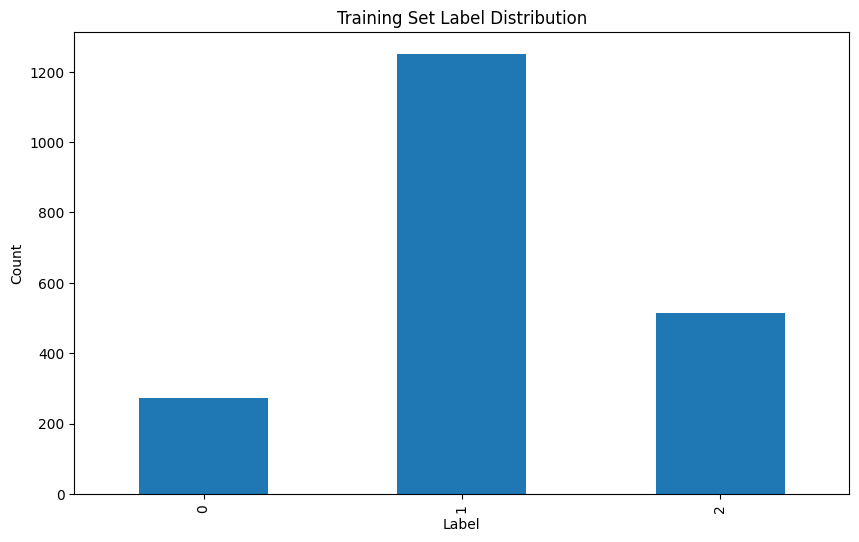

In [5]:
fig = plt.figure(figsize=(10,6))
plt.title('Training Set Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
df_train.groupby('Label').Sentence.count().plot.bar(ylim=0)
plt.show()

#### **Dataset distribution significance**

Often times we are given data that is not perfectly distributed. We can address uneven distributions through word clouds.



## Word Clouds

Word clouds are graphical representations of word frequency that help us better visualize our data. They give greater prominence to words that appear more frequently in a source text.

Let's create and explore the word clouds for each class of data in our dataset!

#### **Negative Data Word Cloud**

Let's create a word cloud of all the sentences labeled with a negative sentiment! This will give us the chance to explore what particular words potentially influence the negative classification.

To do so, first let us obtain all the sentences from the dataset that have a negative label. Thus, we want sentences with `Label` equal to `0`. We filter the original `df_train` dataframe to obtain all the sentences with a negative label. After filtering, we save the result in a variable named `negative_data`. Then we will create our word cloud.

**Note: To filter a dataframe based on the value in a specified column, we can use the code structure: `negative_data = df_train[df_train[column_name] == value]`. We replace `column_name`, and `value` to appropriately filter the dataframe. We should think about what `value` we would need to signify that the sentiment is negative.**

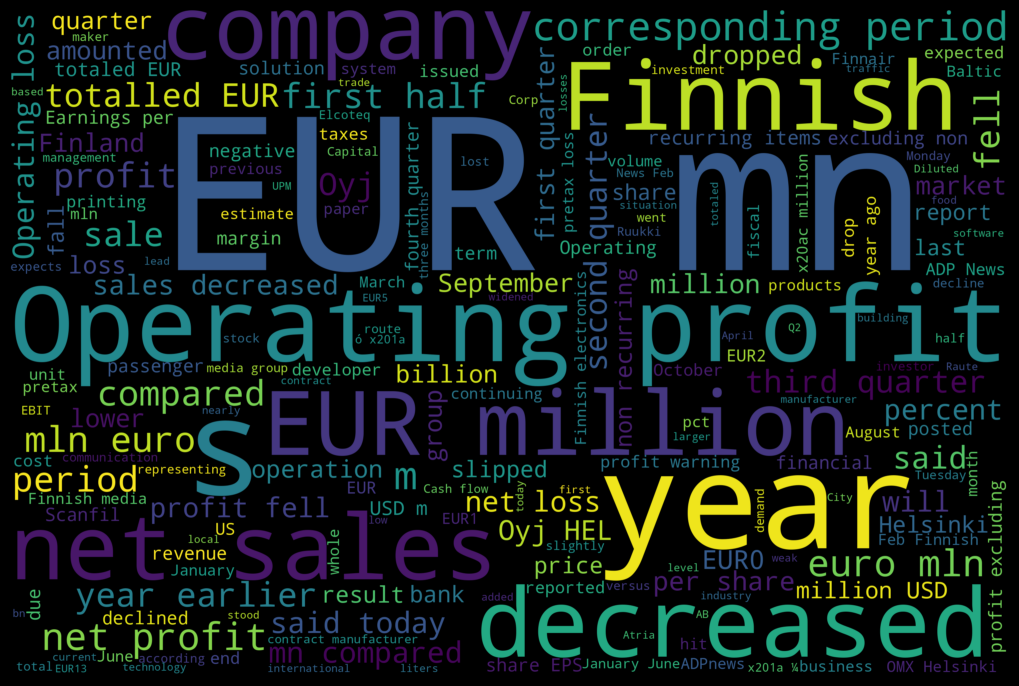

In [6]:
negative_data = df_train.loc[df_train['Label'] == 0]
plot_word_cloud(negative_data)

#### **Positive Data Word Cloud**

Now let's create a word cloud of all the sentences labeled with a positive sentiment!

We will filter the `df_train` dataframe, this time keeping the sentences with positive labels. After filtering, we will save the result in a variable named `positive_data`.

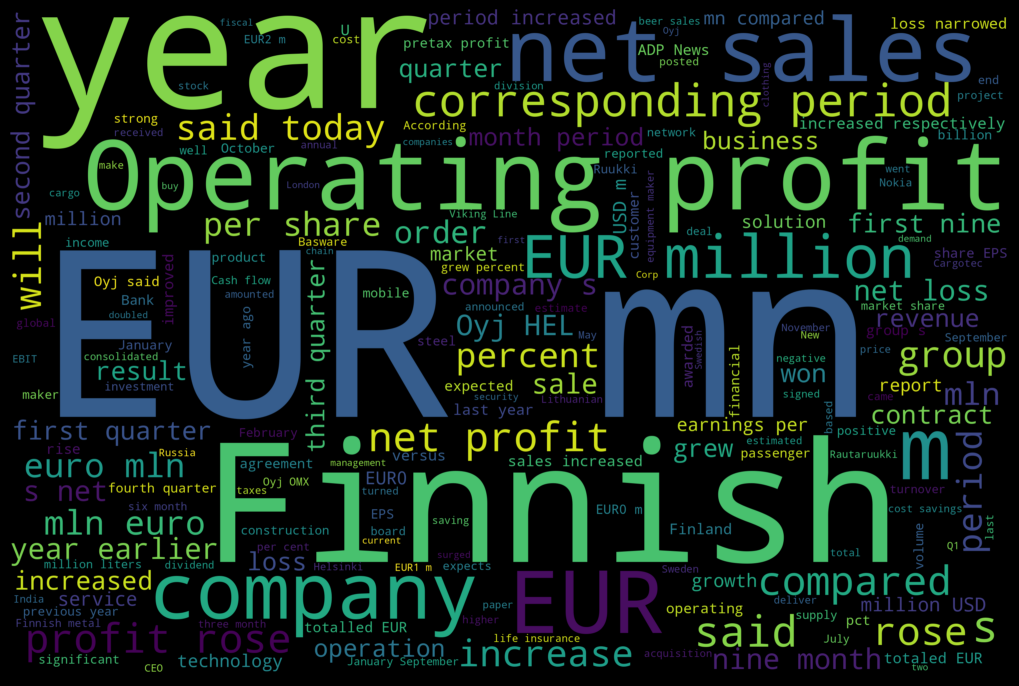

In [7]:
positive_data = df_train.loc[df_train['Label'] == 2]
plot_word_cloud(positive_data)

#### **Neutral Data Word Cloud**

Using the same process as above, we will make the neutral data word cloud.

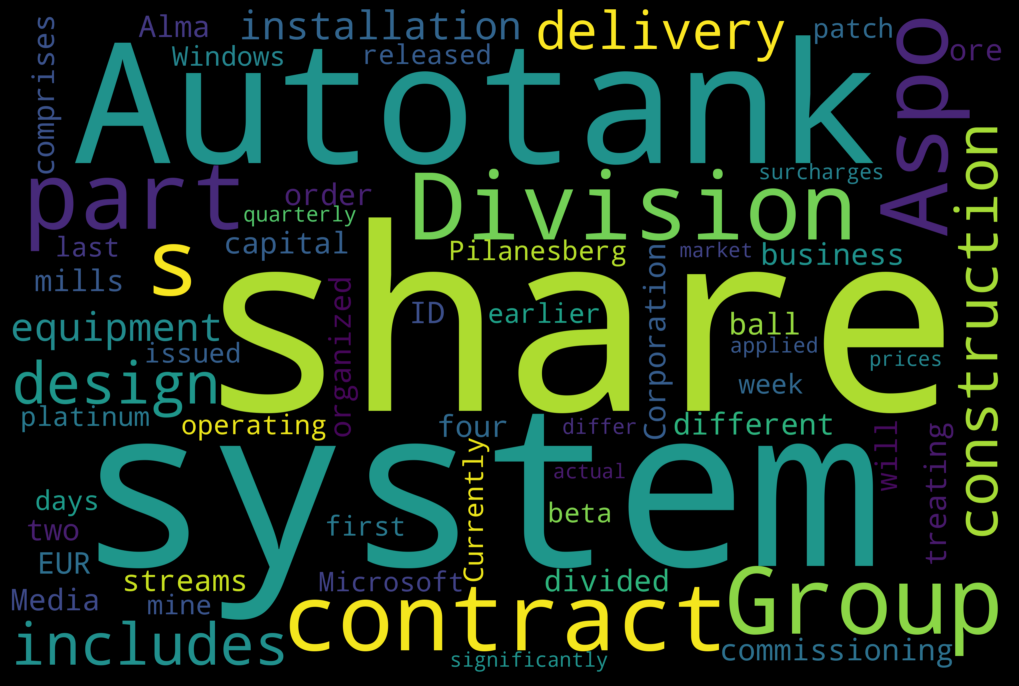

In [8]:
neutral_data = df_train.loc[df_train['Label'] == 1]
plot_word_cloud(neutral_data)

### **Interlude: Sentiment Analysis for Stock Prediction**

Let us stop to consider the impact of the intersection between the fields of NLP and Finance. Specifically, let us consider using the task of sentiment analysis for stock prediction.

The price of stocks fluctuate rapidly and are influenced dramatically by social media platforms. If there is positive or motivating news regarding a stock, many people may invest in it and cause price increases. Whereas if there is negative sentiment regarding a stock, peoples' investing patterns may cause the price to decrease!

A recent example is the monumental fluctuation in the stock price of GameStop Corp. (`GME`) influenced by Reddit. A movement started to increase the stock price and the resulting rhetoric, sentiment, and motivation urged thousands to join in and cause these massive changes as shown [here](https://www.cnn.com/2021/01/30/business/gamestop-reddit-rebellion-explained/index.html).

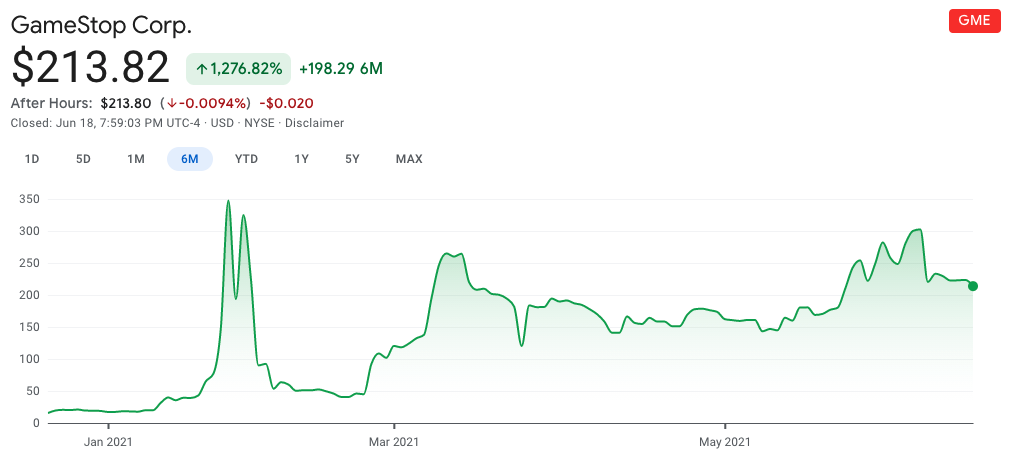

#### **Signficance of NLP + Finance**

**Question**

>What are some ways we could create an ML model to help us predict stock prices?

Stock price prediction using sentiment analysis is a well explored field, as shown [here](https://medium.com/vsinghbisen/how-sentiment-analysis-in-stock-market-used-for-right-prediction-5c1bfe64c233). Before we can effectively create models to predict stock prices using sentiment analysis, we need to be able to accurately analyze sentiment of financial news. That will be the focus in the 3 jupyter notebooks with the aim to create the best sentiment analysis financial news prediction models!

## Text Preprocessing

A signficant part of machine learning model development is properly filtering and processing data for use. The realm of NLP is especially prevalent with techniques to filter and clean text data in a variety of beneficial ways. We will take a look at and apply the techniques of **Tokenization**, **Stemming**, and **Stopword Removal**. Let us take a look at each technique in turn before applying them all to our dataset.

#### **Tokenization**

Tokenization is the process of splitting a string of text into a list of objects. We would like to split the sentences into these objects, which are words or punctuation, before proceeding with the analysis.

**An experiment with tokenization** Write any sentence you'd like in the parameter box below and run the cell to see the list of objects that the tokenizer creates from your input!

In [9]:
#@title Tokenizing
sentence = "Your sentence here!\"" #@param {type:'string'}
tokens = word_tokenize(sentence)
tokens

['Your', 'sentence', 'here', '!', "''"]

#### **Stemming**


Stemming in NLP is the process of removing prefixes and suffixes from words so that they are reduced to simpler forms called stems.

**Experiment with stemming below!** Write any word you'd like in the parameter box below and run the cell to see the generated stem!

In [10]:
#@title Stem words { run: "auto", vertical-output: true, display-mode: "form" }
stemmer = PorterStemmer()
word = "Stemming\"" #@param {type:"string"}
print(stemmer.stem(word[:-1]))

stem


#### **Failed stemming**

The packages and libraries to filter and process code will not work in every situation. Sometimes, tradeoffs are made that make it so some words are incorrectly stemmed.

#### **Stopword Removal**

Stopwords are English words that appear in several contexts, such as 'at', 'is', 'the', and so on. In NLP, it is usually advantageous to ignore these words, since they may add noise or cause numerical issues—and since they appear in *every* context, ignoring them will not impact the meaning of the sentence.


We've created a set called `STOPWORD_SET` that holds the most common stopwords in the English language.

In [11]:
print(STOPWORD_SET)

{'himself', 'to', "it's", 'the', "she's", "you're", 'most', 'because', 't', 'it', 'as', 'yours', 'after', 'them', 'myself', 'was', 'about', "don't", 'ain', 'weren', 'have', 'only', 'theirs', "didn't", 'than', 'further', 'is', 'ours', 'how', 'needn', 'whom', 'few', "should've", 'before', 'each', 'has', 'any', 'yourselves', "shan't", "wasn't", 'we', "mustn't", 'can', 'below', 'an', 'no', 'shan', 'hadn', "needn't", "won't", "mightn't", 'yourself', 'or', 'do', "couldn't", 'own', 'in', "haven't", 'at', 'wasn', 'from', "doesn't", 'hasn', 'under', 'then', 'my', 'themselves', 'other', 'out', 'you', 'so', 'up', 'didn', "isn't", 'until', "weren't", 'his', 'on', 'more', 'some', 'will', 'him', 'wouldn', 'between', 'm', 'above', 'he', 'these', 'o', 'are', 'what', 'hers', 'again', "aren't", "you've", 'doesn', 'mightn', 'such', 'your', 'isn', 'won', 've', 'of', "wouldn't", 'd', 'which', 'ma', 'not', 'couldn', 'into', 'been', 'same', 'if', 'and', "hasn't", "you'll", 'doing', 'for', 'against', 'itself'

**Experiment with stop-words below!** Write any word you'd like and check to see if it is a stopword or not!

In [12]:
#@title Check If Stopword { run: "auto", vertical-output: true, display-mode: "form" }
word = "stopword\"" #@param {type:"string"}
if not word: raise Exception('Please enter a word')
eng_stopwords = set(stopwords.words('english'))
if word[:-1].lower().strip() in eng_stopwords: print('Yes,\"{}'' is a stopword.'.format(word))
else: print('No,\"{}'' is NOT a stopword.'.format(word))



No,"stopword" is NOT a stopword.


#### **Dataset Filtration**

We will use our techniques in **Tokenization**, **Stemming**, and **Stopword Removal** from above to filter our training and testing datasets. To get started, we will create a function named `remove_stopwords(sentence)` that takes a single tokenized sentence (list of token objects) and returns a new filtered list with all the stopwords removed. To make the filtration process possible, we use `STOPWORD_SET`, a list of all the stopwords in the English language.

Let's look at the sample input and output below so we can create our function!

In [13]:
#@title Sample Input and Output

print('Sample Input:\t{}'.format(SAMPLE_SENTENCE))
print('Sample Output:\t{}'.format(SAMPLE_SOLUTION))

def remove_stopwords(tokenized_sentence):
  filtered_sentence = []
  for w in tokenized_sentence:
    if w not in STOPWORD_SET: filtered_sentence.append(w)
  return filtered_sentence

Sample Input:	['I', 'need', 'to', 'remove', 'all', 'these', 'meaningless', 'stopwords', '.']
Sample Output:	['I', 'need', 'remove', 'meaningless', 'stopwords', '.']


**Let's call our code on the sentence from above, named `SAMPLE_SENTENCE`, to verify that we get the same output!**

In [14]:
remove_stopwords(SAMPLE_SENTENCE)

['I', 'need', 'remove', 'meaningless', 'stopwords', '.']

Now, we will apply the filtration to our entire training and testing datasets! To do so, we call the `preprocess_data(DATA)` function passing in `df_train` for data. This function will return a list of all the filtered sentences and their respective labels: so, we need to save this result two variables named `train_sentences` and `train_labels`. Thereafter, we can print the first few elements of `train_sentences` to assess our preprocessing!

In [15]:
train_sentences, train_labels = preprocess_data(df_train)
for sentence in train_sentences[:3]:
    print(sentence)

['Autotank', 'Group', 'part', 'Aspo', "'s", 'Systems', 'Division', '.']
['The', 'contract', 'includes', 'design', ',', 'construction', ',', 'delivery', 'equipment', ',', 'installation', 'commissioning', '.']
['Rapala', 'said', 'estimates', 'make', 'savings', '1-2', 'mln', 'eur', 'year', 'centralising', 'French', 'operations', 'one', 'site', '.']


Similarly preprocess our test data and save the result in a variable named `test_sentences`. We print the first few elements of `test_sentences` to assess the preprocessing.

In [16]:
test_sentences, test_labels = preprocess_data(df_test)
for sentence in test_sentences[:3]:
    print(sentence)

['In', 'third', 'quarter', '2010', ',', 'net', 'sales', 'increased', '5.2', '%', 'EUR', '205.5', 'mn', ',', 'operating', 'profit', '34.9', '%', 'EUR', '23.5', 'mn', '.']
['Foundries', 'division', 'reports', 'sales', 'increased', '9.7', '%', 'EUR', '63.1', 'mn', 'EUR', '57.5', 'mn', 'corresponding', 'period', '2006', ',', 'sales', 'Machine', 'Shop', 'division', 'increased', '16.4', '%', 'EUR', '41.2', 'mn', 'EUR', '35.4', 'mn', 'corresponding', 'period', '2006', '.']
['Financing', 'project', 'come', 'mainly', 'China', '.']


# **Build a baseline model for the task of financial news sentiment classification.**

In the world of machine learning, we want to be able to create models quickly and iterate on them continuously to rapidly arrive at solutions to our problems. To start us off, we will begin with a simple and quick-to-implement model to analyze our financial news sentences: Logistic Regression!

**What are the benefits of a Logistic Regression model and why may it be useful to use for this application?**

1. It is a simple baseline models tells us how much room there is to improve.
2. Model iteration is quick and easy.
3. Logistic regression is interpretable. It is often extremely important that one is able to understand why a model is making specific predictions, and Logistic Regression gives us this ability.

## Engineering features

Part of the NLP process is the creation of features from language data. Now that we have fully filtered our input sentences, we can now take the next step to generate feature vectors for each of the examples to use in our ML model. To create features from the filtered input sentences, we will use the technique: **Bag of Words**!

Recall that Bag of Words is a manner of transforming text into computational data by recording the frequency of words. This process is referred to as vectorization.

We will consider **Sentence A** below and its conversion to a vector representation.

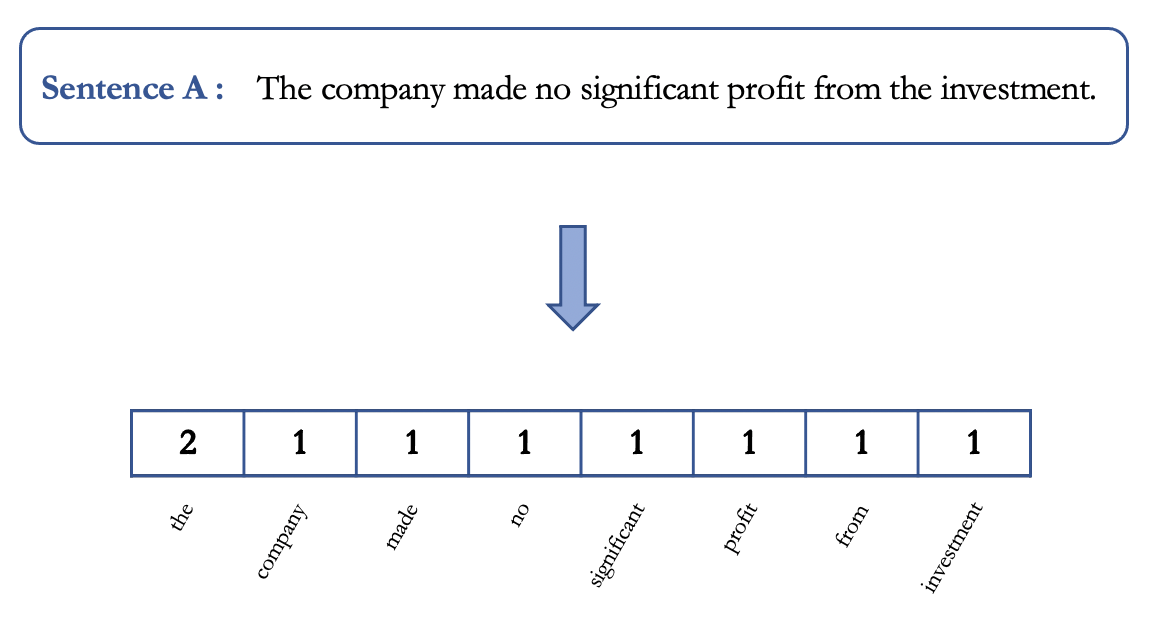

#### **Bag-of-Words using CountVectorizer**

To carry out Bag-of-Words, we will be using an object known as a `CountVectorizer` from the `sklearn` library. A `CountVectorizer` is used to convert a collection of text (in our case, a list of financial news sentences) into a vector of word counts. It also enables us to ​pre-process our text before turning it into a vector. This makes `CountVectorizer` a highly flexible way to represent text as numerical input.

Before applying the `CountVectorizer` to our data, let us take a look at how to use it!

In [17]:
# List of sentences
all_sentences = ["Google AI made remarkable achievements in 2019.", "Google Stock was at its all time high"]

#Create instance of CountVectorizer() object
vectorizer = CountVectorizer()

`CountVectorizer`'s `.fit()` method learns about the text (it's length, vocabulary, etc.).

In [18]:
# Tokenizes the text and builds the vocabulary
vectorizer.fit(all_sentences)

CountVectorizer()

`CountVectorizer`'s `.transform()` method turns the sentences into their Bag-of-Words vector representations.

In [19]:
# Encode sentences as a vectors
bag_of_words_matrix = vectorizer.transform(all_sentences).toarray()

# Print vectors
print(bag_of_words_matrix)

[[1 1 1 0 0 1 0 1 0 1 1 0 0 0]
 [0 0 0 1 1 1 1 0 1 0 0 1 1 1]]


Let's print the shape of `bag_of_words_matrix` initialized above!

In [20]:
print(bag_of_words_matrix.shape)

(2, 14)


## Logistic Regression for Sentiment Classification

Now we will piece together our preprocessing techniques to create and run our model!

#### **Training our model!**

We will vectorize our data below using the `CountVectorizer`. Then, we train a `LogisticRegression()` and pass in the training data matrix and labels.

In [21]:
def train_model(train_sentences, train_labels):
  """
  param: train_sentences - list of pre-processed sentences to train on
  param: train_labels - list of labels (positive, neutral, negative) for each sentence in train_sentences
  return: the vectorizer, the Logistic Regression model
  """
  train_sentences = [" ".join(t) for t in train_sentences]
  train_labels = [l for l in train_labels]
  vectorizer = CountVectorizer()
  vectorizer.fit(train_sentences)
  train_vect = vectorizer.transform(train_sentences)
  #NOTE: Can also use train_vect = vectorizer.fit_transform(train_sentences)
  model = LogisticRegression()
  model.fit(train_vect, train_labels)
  return model, vectorizer

We train our model by calling the `train_model()` function while passing in our previously initialized `train_sentences` and `train_labels` from above. We then save the result in variables named `model` and `train_vectorizer`.

In [22]:
model, train_vectorizer = train_model(train_sentences, train_labels)

#### **Testing our model!**

We fill out the code below to get the vector representation of the test sentences and evaluate the accuracy of the model.

In [23]:
def predict(test_sentences, test_labels, vectorizer, model):
  """
  param: test_sentences - list of pre-processed sentences to test the model
  param: vectorizer - the CountVectorizer from the train_model function
  param: model - the Logistic Regression model from the train_model function
  return: preds - the predictions of the model based on test_sentences
  """
  test_sentences = [" ".join(t) for t in  test_sentences]
  test_vect = vectorizer.transform(test_sentences)
  preds = model.predict(test_vect)
  acc = metrics.accuracy_score(test_labels, preds)
  return preds, acc

We should try running our code to test our model! We call the `predict()` function while passing in our previously initialized `test_sentences`, `test_labels`, `train_vectorizer`, and `model` from above. We then save the predicitions and accuracy result in variables named `y_predictions` and `test_accuracy`. We print the accuracy results to assess our performance!

In [24]:
y_predictions, test_accuracy = predict(test_sentences, test_labels, train_vectorizer, model)
print('The model had an accuracy of {:.2%} on the test dataset'.format(test_accuracy))

The model had an accuracy of 85.46% on the test dataset


# **Assess and visualize our results using a confusion matrix.**



Running a model and obtaining great results is beneficial and important. However, being able to understand the significance of our results is arguably more important. A foundational understanding of the results can help one to iterate over and improve on their model. Let us take some time to create and understand the confusion matrix results of our classification model.

Plotting the Confusion Matrix


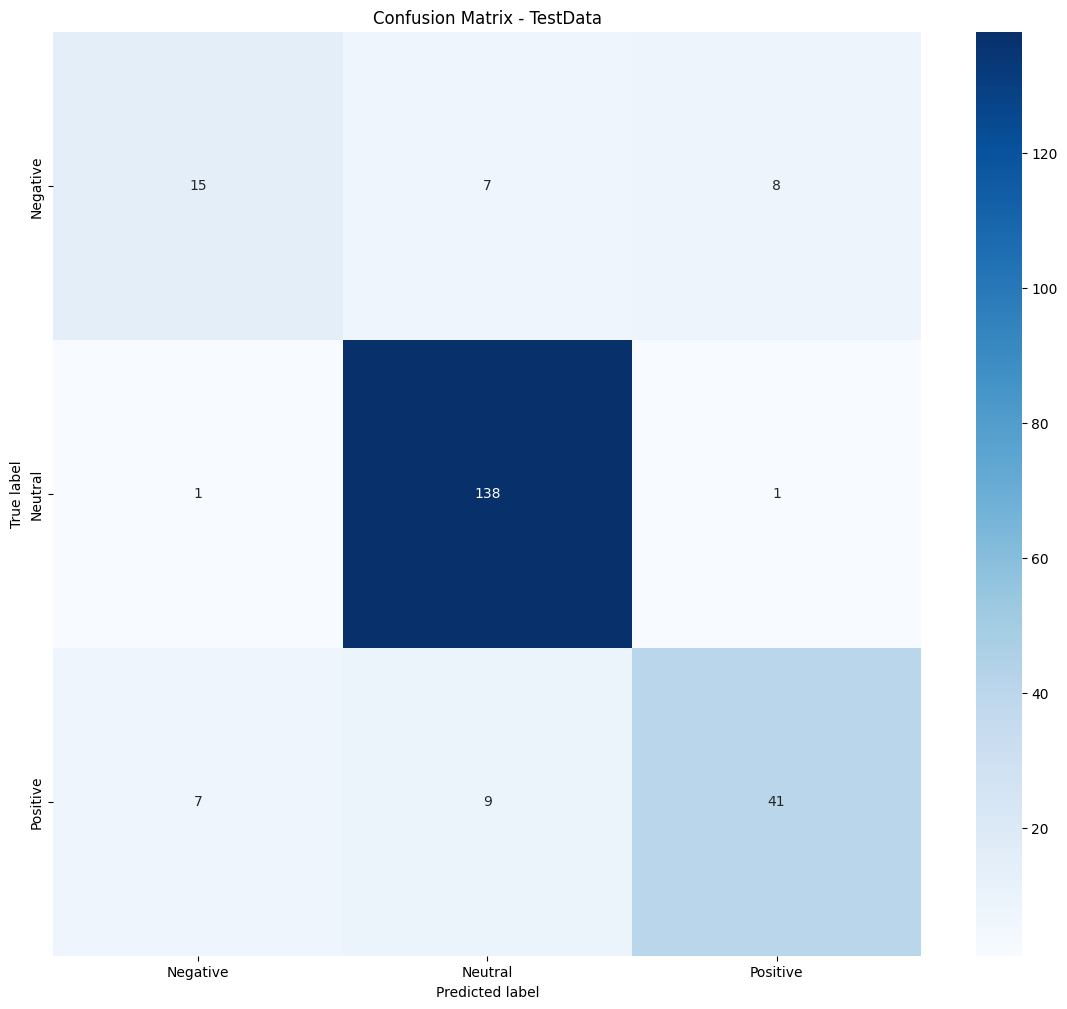

In [25]:
plot_confusion_matrix(test_labels, y_predictions)